In [1]:

import numpy as np, pandas as pd
from shapely import *
import sys
sys.path.append('/Users/spaul/pcbflow/') 
from pcbflow import *
#skidl requires imp (https://integrativemodeling.org/)
from skidl import *
import os
#import beampipe_parameters

In [2]:

import os
path = "mypcb"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)

In [3]:
def hxrt(A):
    return np.sqrt(A/(3*np.sqrt(3)/2))

In [4]:
from pcbflow import *

def make_board(layer, side):
    df=pd.read_csv(f"insert_layout/PCB_edges_{layer}{side}.csv")
    x=-df.x*10
    y=df.y*10
    #print(x,y)
    height=max(y)-min(y)
    width=max(x)-min(x)
    brd = Board((width, height))
    #brd.add_outline()
    offset=[np.min(x), np.min(y)]
    x-=np.min(x)
    y-=np.min(y)
    brd.layers["GML"].lines.append(LinearRing(zip(x,y)))
    brd.add_inner_copper_layer(4)
    #help(brd)
    brd.body()
    
    return brd, offset
# fill the top and bottom copper layers and merge nets named "GND"
#brd.fill_layer("GTL", "GND")
#brd.fill_layer("GBL", "GND")

# save the PCB asset files
brd,offset = make_board(1,"L")
brd.save("test_outline")

Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...


In [5]:
def outline_polygon(brd, xy):
    dc=brd.DC(xy[0])
    dc.push()
    dc.newpath()
    olddir=90
    for j in range(len(xy)-1):
        #help(dc.goto)    
        t=xy[j+1][1]-xy[j][1],xy[j+1][0]-xy[j][0]
        newdir=180/np.pi*np.arctan2(*t)
        dc.left(newdir-olddir)
        dc.forward(np.hypot(xy[j+1][1]-xy[j][1],xy[j+1][0]-xy[j][0]))
        olddir=newdir
    dc.silk('top')
    dc.pop()

In [12]:
def add_SiPMs(brd, layer, side, offset):
    df=pd.read_csv(f"insert_layout/SiPM_positions_{layer}{side}.csv")
    x=-df.x*10-offset[0]
    y=df.y*10-offset[1]
    r=hxrt(df.area[0]*100)
    #create a hexagon
    phi=np.linspace(0, 2*np.pi, 7)
    
    #add these to the dict of layer names
    import pcbflow.kicad as kicad
    kicad.KI_LAYER_DICT["F.CrtYd"]="GTO"
    kicad.KI_LAYER_DICT['"F.SilkS"']=kicad.KI_LAYER_DICT['F.SilkS']
    kicad.KI_LAYER_DICT['"F.Fab"']= kicad.KI_LAYER_DICT['F.Fab']
    kicad.KI_LAYER_DICT['"F.Cu"']= kicad.KI_LAYER_DICT['F.Cu']
    
    for xi,yi in zip(x,y):
        #brd.add_text((xi,yi), "SiPM")
        outline_polygon(brd, list(zip(xi+np.cos(phi)*r,yi+np.sin(phi)*r)))
        #brd.layers["GTS"].lines.append(LinearRing(zip(xi+np.cos(phi)*ri,yi+np.sin(phi)*r)))
        KiCadPart(brd.DC((xi, yi)), libraryfile="footprints/SiPM_test.kicad_mod")
# test this method
brd,offset = make_board(1,"L")
add_SiPMs(brd, 1, "L", offset)
brd.save("test_sipm")

Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...


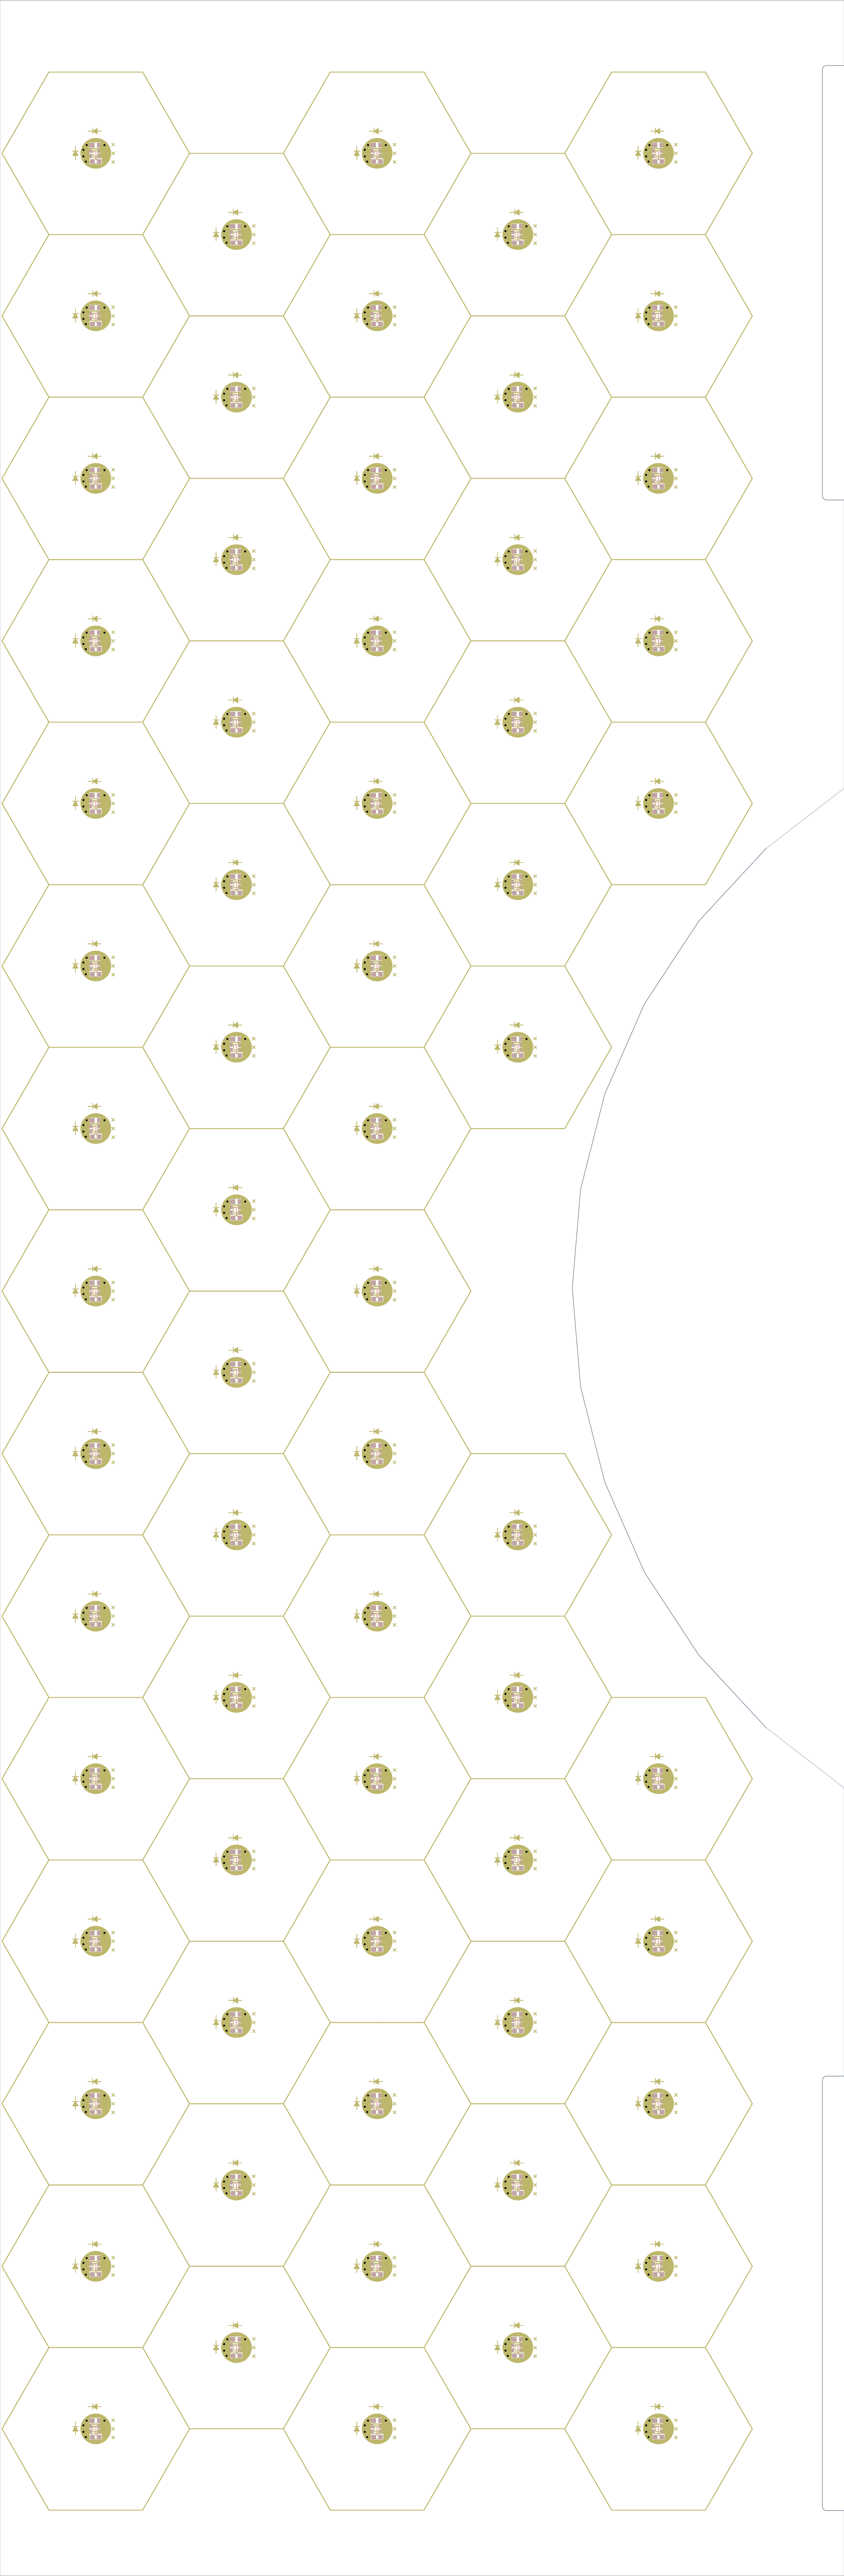

In [13]:
# to view the pdf in the jupyter notebook (without having to switch back and forth with another application),
# use the "wand" package, which in turn requires another library called imagemagick.
#!pip install wand
#!pip install imagemagick
from wand.image import Image as WImage
img = WImage(filename='test_sipm/test_sipm_preview_all.pdf')
img

In [8]:
path = f"pcb_output"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)

In [9]:
help(brd.save)

Help on method save in module pcbflow.board:

save(basename, in_subdir=True, gerber=True, pdf=True, bom=True, centroids=True, povray=False, subdir=None) method of pcbflow.board.Board instance



In [10]:
for layer in range(1, 60+1):
    for side in "LR":
        brd,offset = make_board(layer,side)
        add_SiPMs(brd, layer, side, offset)
        path = f"pcb_output/{layer}{side}"
        # Check whether the specified path exists or not
        isExist = os.path.exists(path)
        if not isExist:
           # Create a new directory because it does not exist
           os.makedirs(path)
        brd.save(path.split('/')[-1], subdir=path.split('/')[0])
        print("done with layer ", layer, "side", side)

Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  1 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering p

Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  7 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  8 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering G

Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  14 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  15 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...


Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  21 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  22 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...


Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  28 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  29 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...


Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  35 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  36 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...


Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  42 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  43 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...


Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  49 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  50 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GB

Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  56 side R
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber GP2...
Rendering Gerber GP3...
Rendering Gerber GP4...
Rendering Gerber GP5...
Rendering excellon drill files...
Rendering preview_top.['pdf']...
Rendering preview_top_docu.['pdf']...
Rendering preview_bot.['pdf']...
Rendering preview_bot_docu.['pdf']...
Rendering preview_all.['pdf']...
done with layer  57 side L
Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GB